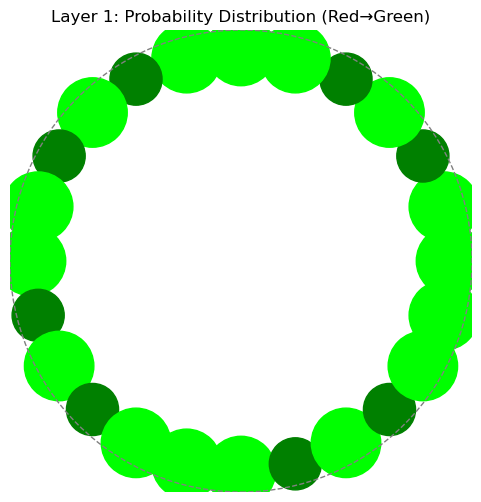

In [13]:
%matplotlib inline
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Problem Setup
n_ambassadors = 4
enemies = {(0,1), (2,3)}

states = list(itertools.permutations(range(n_ambassadors)))
n_states = len(states)

def cost(seating):
    """Number of hostile neighbor pairs"""
    c = 0
    for i in range(n_ambassadors):
        a = seating[i]
        b = seating[(i+1)%n_ambassadors]
        if (a,b) in enemies or (b,a) in enemies:
            c += 1
    return c

costs = np.array([cost(s) for s in states])

# QAOA Functions
psi = np.ones(n_states, dtype=complex) / np.sqrt(n_states)

def apply_cost_layer(psi, gamma):
    return psi * np.exp(-1j * gamma * costs)

def apply_mixer_layer(psi, beta):
    mix_matrix = np.ones((n_states, n_states)) / n_states
    return np.cos(beta) * psi + 1j * np.sin(beta) * mix_matrix.dot(psi)

# Circle Setup
steps = 15
gamma = 1.0
beta = 0.6
threshold = 0.05  # hide very small probabilities

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')
ax.axis('off')

angles = np.linspace(0, 2*np.pi, n_states, endpoint=False)
x = np.cos(angles)
y = np.sin(angles)

# Initial colors: red if cost>0, green if cost==0
colors = ['red' if c>0 else 'green' for c in costs]
sizes = np.ones(n_states)*500
markers = ax.scatter(x, y, s=sizes, c=colors)

# Circle outline
circle = plt.Circle((0,0), 1.1, fill=False, linestyle='--', color='gray')
ax.add_artist(circle)

# Animation Function

def animate(frame):
    global psi
    psi = apply_cost_layer(psi, gamma)
    psi = apply_mixer_layer(psi, beta)
    
    probs = np.abs(psi)**2
    probs_scaled = probs / probs.max()
    
    # Scale marker sizes by probability
    sizes = 500 + 2000*probs_scaled
    sizes[probs_scaled < threshold] = 0  # hide very small probabilities
    markers.set_sizes(sizes) 
# Update colors: interpolate red → green based on probability
    new_colors = []
    for i, c in enumerate(costs):
        if c==0:
            new_colors.append('green')  # already optimal
        else:
            ratio = probs_scaled[i]
            r = 1 - ratio
            g = ratio
            new_colors.append((r,g,0))
    markers.set_facecolor(new_colors)
    ax.set_title(f"Layer {frame+1}: Probability Distribution (Red→Green)")
    return markers,
anim = FuncAnimation(fig, animate, frames=steps, interval=800, blit=False)
# Display inline HTML animation
HTML(anim.to_jshtml())

